In [1]:
import pandas as pd
import numpy as np
import re
import string
import random

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/sithum/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sithum/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sithum/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/sithum/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [6]:
DATA_PATH = "./dataset/Amazon_Unlocked_Mobile.csv"

In [7]:
df = pd.read_csv(DATA_PATH)

In [8]:
df = df.dropna(subset=['Reviews'])

In [9]:
df_sample = df.sample(n=2000, random_state=42).reset_index(drop=True)

In [10]:
df_sample['Original'] = df_sample['Reviews'].astype(str)

In [11]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text(text: str) -> str:
    """
    Basic cleaning:
    - Lowercase
    - Remove HTML tags
    - Remove URLs
    - Remove digits
    - Remove punctuation
    - Remove extra spaces
    Returns a cleaned string (still needs tokenization).
    """
    # Lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', ' ', text)
    
    # Remove digits
    text = re.sub(r'\d+', ' ', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def tokenize_and_remove_stopwords(text: str):
    """
    Tokenize using NLTK and remove English stopwords.
    Returns a list of tokens.
    """
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return tokens

def stem_tokens(tokens):
    """Apply Porter stemming to a list of tokens."""
    return [stemmer.stem(t) for t in tokens]

def lemmatize_tokens(tokens):
    """Apply WordNet lemmatization to a list of tokens (assuming nouns by default)."""
    return [lemmatizer.lemmatize(t) for t in tokens]


In [12]:
# -------------------------------------------------------------------
# 4. Apply the preprocessing to the sampled reviews
# -------------------------------------------------------------------

# Step 1: cleaned (string)
df_sample['Cleaned'] = df_sample['Original'].apply(clean_text)

# Step 2: tokenization + stopword removal
df_sample['Tokens'] = df_sample['Cleaned'].apply(tokenize_and_remove_stopwords)

# Step 3: stemming and lemmatization
df_sample['Stemmed_Tokens'] = df_sample['Tokens'].apply(stem_tokens)
df_sample['Lemmatized_Tokens'] = df_sample['Tokens'].apply(lemmatize_tokens)

# Convert lists of tokens back to strings for table display
df_sample['Stemmed'] = df_sample['Stemmed_Tokens'].apply(lambda toks: " ".join(toks))
df_sample['Lemmatized'] = df_sample['Lemmatized_Tokens'].apply(lambda toks: " ".join(toks))


In [14]:
# -------------------------------------------------------------------
# 5. Before vs After table for 5 random samples
# -------------------------------------------------------------------

sample_rows = df_sample.sample(n=5, random_state=123).copy()

preview_table = sample_rows[['Original', 'Cleaned', 'Stemmed', 'Lemmatized']]


In [15]:
# Show nicely in Jupyter
preview_table
# or: print(preview_table.to_string(index=False))

,Original,Cleaned,Stemmed,Lemmatized
1342,excelente,excelente,excelent,excelente
1338,fine,fine,fine,fine
189,BUENO,bueno,bueno,bueno
1332,LG G2 D800 Unlocked AT&T Smartphone Android 4G...,lg g d unlocked att smartphone android g lte g...,unlock att smartphon android lte ghz quadcor m...,unlocked att smartphone android lte ghz quadco...
1816,bueno,bueno,bueno,bueno


# Part B

In [16]:
# Part B – TF-IDF Feature Extraction

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer


In [17]:
# -------------------------------------------------------------------
# 1. Prepare corpus for TF-IDF
# -------------------------------------------------------------------
# We use the lemmatized text from Part A for a cleaner vocabulary.
# If your column name differs, adjust here.
corpus = df_sample['Lemmatized'].astype(str).tolist()

print(f"Number of documents in corpus: {len(corpus)}")


Number of documents in corpus: 2000


In [18]:
# -------------------------------------------------------------------
# 2. Construct TF-IDF representation
# -------------------------------------------------------------------
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.8,      # ignore terms that appear in >80% of documents (too common)
    min_df=5,        # ignore terms that appear in <5 documents (too rare)
    stop_words=None  # we already removed stopwords in preprocessing
)

X_tfidf = tfidf_vectorizer.fit_transform(corpus)
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

print("TF-IDF matrix shape:", X_tfidf.shape)  # (n_docs, n_terms)

TF-IDF matrix shape: (2000, 1181)


In [19]:
# -------------------------------------------------------------------
# 3. Extract top-N words by average TF-IDF across the corpus
# -------------------------------------------------------------------
top_n = 10

# Mean TF-IDF score for each term over all documents
mean_tfidf = X_tfidf.mean(axis=0).A1   # convert from sparse -> 1D array

# Indices of top-N terms
top_indices = mean_tfidf.argsort()[::-1][:top_n]

top_terms = feature_names[top_indices]
top_scores = mean_tfidf[top_indices]

tfidf_top_table = pd.DataFrame({
    "Rank": np.arange(1, top_n + 1),
    "Term": top_terms,
    "Mean_TF_IDF": top_scores
})

# Display the table in notebook
tfidf_top_table
# Or: print(tfidf_top_table.to_string(index=False))

,Rank,Term,Mean_TF_IDF
0,1,phone,0.090490
1,2,good,0.063524
2,3,great,0.054176
3,4,love,0.038359
4,5,work,0.038241
5,6,excellent,0.031714
6,7,product,0.025014
7,8,like,0.018623
8,9,price,0.018589
9,10,one,0.017437


# part c

In [22]:
# Part C – POS Tagging & Named Entity Recognition

%pip install spacy
%pip install spacy[transformers]
!python -m spacy download en_core_web_sm

import pandas as pd
import spacy

nlp = spacy.load("en_core_web_sm")


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 725.8/725.8 KB 715.5 kB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 921.5 kB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.5/314.5 KB 1.1 MB/s eta 0:00:001m879.2 kB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 929.8 kB/s eta 0:00:00m eta 0:00:010:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.0
    Uninstalling tokenizers-0.22.0:
      Successfully uninstalled tokenizers-0.22.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.56.1
    Uninstalling transformers-4.56.1:
      Successfully uninstalled transformers-4.56.1
Note: you may need to

In [23]:
# -------------------------------------------------------------------
# 1. Sample a few reviews for qualitative analysis
# -------------------------------------------------------------------
pos_ner_sample = df_sample.sample(n=5, random_state=77).copy()

def get_pos_tags(doc):
    """Return a compact string like 'great/ADJ phone/NOUN ...' for a spaCy doc."""
    return " ".join([f"{token.text}/{token.pos_}" for token in doc])

def get_entities(doc):
    """Return entities as 'text (LABEL)' joined by commas."""
    if not doc.ents:
        return ""
    return ", ".join([f"{ent.text} ({ent.label_})" for ent in doc.ents])

# Process the 5 documents with spaCy
docs = list(nlp.pipe(pos_ner_sample['Original'].tolist()))

pos_tags_list = [get_pos_tags(doc) for doc in docs]
entities_list = [get_entities(doc) for doc in docs]

pos_ner_sample['POS_Tags'] = pos_tags_list
pos_ner_sample['Named_Entities'] = entities_list

pos_ner_preview = pos_ner_sample[['Original', 'POS_Tags', 'Named_Entities']]
pos_ner_preview


,Original,POS_Tags,Named_Entities
534,Nicer and bigger than I expected compared to o...,Nicer/PROPN and/CCONJ bigger/ADJ than/SCONJ I/...,
323,The touch-screen system is REALLY BAD. When wr...,The/DET touch/NOUN -/PUNCT screen/NOUN system/...,"REALLY BAD (ORG), 4 (CARDINAL), LTE (ORG), 64 ..."
1082,I just left his phone and it arrived today and...,I/PRON just/ADV left/VERB his/PRON phone/NOUN ...,"today (DATE), a year (DATE), December (DATE)"
1450,Overall for what it is and price isn't bad but...,Overall/ADV for/ADP what/PRON it/PRON is/AUX a...,
1436,"Tiny but fully functional,a bit hard to fill i...","Tiny/ADJ but/CCONJ fully/ADV functional/ADJ ,/...",


In [24]:
# -------------------------------------------------------------------
# 2. Extract PRODUCT, ORG, DATE entities from a larger subset
# -------------------------------------------------------------------

from collections import Counter

# Use up to 500 reviews for speed (you can increase if your machine is fast)
ner_subset = df_sample.sample(n=min(500, len(df_sample)), random_state=101)['Original'].tolist()

entity_counter = Counter()
entity_examples = {"PRODUCT": set(), "ORG": set(), "DATE": set()}

for doc in nlp.pipe(ner_subset, batch_size=32, n_process=1):
    for ent in doc.ents:
        if ent.label_ in ["PRODUCT", "ORG", "DATE"]:
            entity_counter[(ent.text, ent.label_)] += 1
            # Save a few unique examples per entity type
            if len(entity_examples[ent.label_]) < 10:
                entity_examples[ent.label_].add(ent.text)

# Turn counts into a small DataFrame
entity_rows = [
    {
        "Entity_Text": text,
        "Label": label,
        "Count": count
    }
    for (text, label), count in entity_counter.most_common(20)  # top 20 by frequency
]

entities_summary_df = pd.DataFrame(entity_rows)

entities_summary_df


,Entity_Text,Label,Count
0,Amazon,ORG,17
1,Samsung,ORG,16
2,Android,ORG,14
3,SIM,ORG,13
4,Nokia,ORG,11
5,AT&T,ORG,9
6,BLU,ORG,7
7,Google,ORG,6
8,ATT,ORG,6
9,T-Mobile,ORG,5


# partD

In [27]:
# Part D – Topic Modelling (LDA)

%pip install gensim
%pip install seaborn

import gensim
from gensim import corpora
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------------------------
# 1. Prepare tokens for LDA
# -------------------------------------------------------------------
tokens = df_sample['Lemmatized_Tokens'].tolist()

# Create dictionary and corpus
dictionary = corpora.Dictionary(tokens)

# Filter extreme terms (optional but improves quality)
dictionary.filter_extremes(no_below=5, no_above=0.8)

corpus = [dictionary.doc2bow(text) for text in tokens]

# -------------------------------------------------------------------
# 2. Train LDA model with 3 topics
# -------------------------------------------------------------------
lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=3,
    passes=10,
    random_state=42
)

# -------------------------------------------------------------------
# 3. Print top keywords per topic
# -------------------------------------------------------------------
topics_keywords = lda_model.print_topics(num_words=10)
print("\n=== LDA Top Topics ===")
for i, topic in enumerate(topics_keywords):
    print(f"Topic {i+1}: {topic}\n")


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 825.4 kB/s eta 0:00:001m824.6 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.

=== LDA Top Topics ===
Topic 1: (0, '0.073*"phone" + 0.015*"one" + 0.013*"work" + 0.012*"new" + 0.011*"would" + 0.010*"great" + 0.008*"time" + 0.008*"battery" + 0.007*"screen" + 0.007*"like"')

Topic 2: (1, '0.034*"phone" + 0.014*"get" + 0.012*"use" + 0.011*"work" + 0.009*"one" + 0.009*"cant" + 0.008*"dont" + 0.008*"screen" + 0.008*"like" + 0.008*"time"')

Topic 3: (2, '0.075*"phone" + 0.028*"good" + 0.026*"great" + 0.015*"work" + 0.014*"love" + 0.012*"product" + 0.010*"excellent" + 0.010*"like" + 0.009*"battery" + 0.009*"use"')



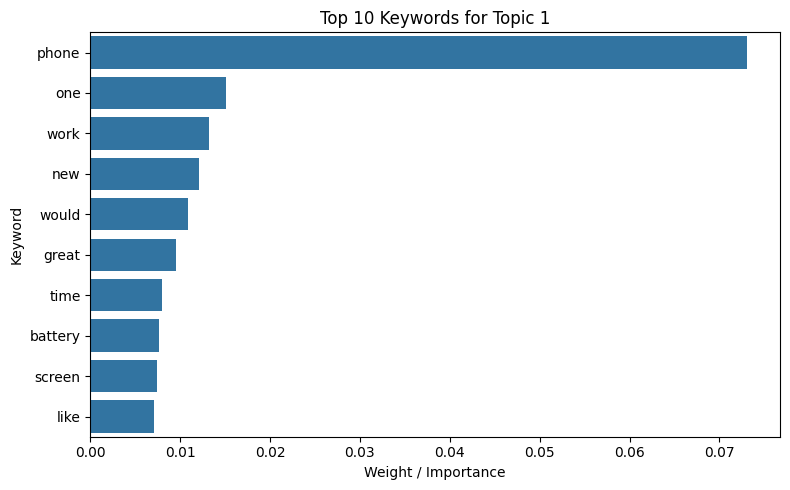

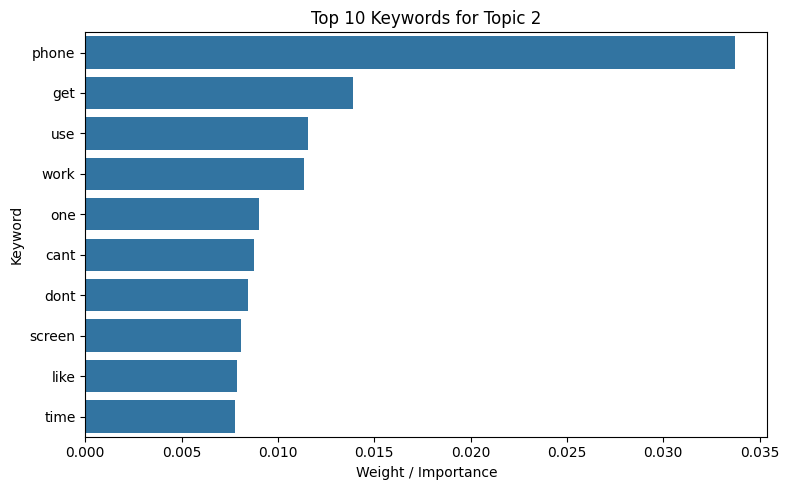

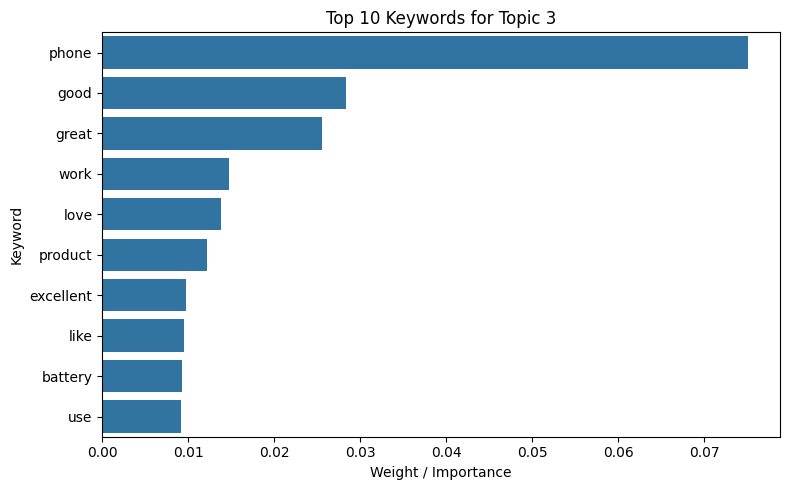

In [28]:
# -------------------------------------------------------------------
# 4. Visualize each topic with a bar chart
# -------------------------------------------------------------------

def plot_topic_keywords(topic_num, lda_model, n_words=10):
    terms = lda_model.show_topic(topic_num, topn=n_words)
    words = [w for w, p in terms]
    weights = [p for w, p in terms]

    plt.figure(figsize=(8,5))
    sns.barplot(x=weights, y=words, orient='h')
    plt.title(f"Top {n_words} Keywords for Topic {topic_num+1}")
    plt.xlabel("Weight / Importance")
    plt.ylabel("Keyword")
    plt.tight_layout()
    plt.show()

# Plot all 3 topics
for t in range(3):
    plot_topic_keywords(t, lda_model)


# part e

In [29]:
# Part E – Sentiment Analysis (VADER)

import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download if needed
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

# -------------------------------------------------------------------
# 1. Apply sentiment scoring to each review
# -------------------------------------------------------------------

def classify_sentiment(text):
    scores = sid.polarity_scores(text)
    compound = scores['compound']
    if compound >= 0.05:
        return "Positive"
    elif compound <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df_sample['Sentiment'] = df_sample['Original'].apply(classify_sentiment)

df_sample[['Original', 'Sentiment']].head()


,Original,Sentiment
0,I needed a texting phone that did not require ...,Positive
1,Excellent!,Positive
2,I recommend this excellent team for the many d...,Positive
3,updated review. Purchased this phone on Novemb...,Positive
4,battery fail,Negative


/tmp/ipykernel_109908/3081271752.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df_sample, palette='viridis')


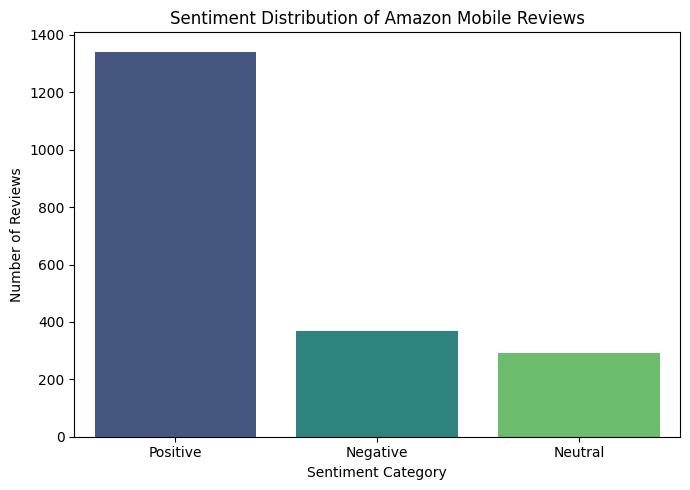

In [30]:
# -------------------------------------------------------------------
# 2. Bar chart of sentiment distribution
# -------------------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,5))
sns.countplot(x='Sentiment', data=df_sample, palette='viridis')
plt.title("Sentiment Distribution of Amazon Mobile Reviews")
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()


In [31]:
# -------------------------------------------------------------------
# 3. Analyse potential misclassifications
# -------------------------------------------------------------------

failure_cases = []

for idx, row in df_sample.iterrows():
    text = row['Original']
    sentiment = row['Sentiment']
    compound = sid.polarity_scores(text)['compound']
    
    # Heuristics for suspicious predictions:
    # 1. Contains overt negative words but classified as Positive
    # 2. Contains overt positive words but classified as Negative
    # 3. Long review with both positive and negative indicators
    if ("but" in text.lower() and sentiment == "Positive") or \
       ("terrible" in text.lower() and sentiment == "Positive") or \
       ("great" in text.lower() and sentiment == "Negative"):
        failure_cases.append((text, sentiment, compound))

# Show up to 5 examples
failure_cases[:5]


[("I was very excite when this arrived due to all the great review. Right of the bat, the phone said I am on a lower IOS update so it won't be able to transfer my content from my old iPhone to this. But I ignored it. I had to individually redownload all my apps. Netflix won't work. It won't let me update my iOS. Has Chinese lettering in the back, like wtf. So many problems with this. I wish I could return this or get a replacement because this is bull-crap",
  'Negative',
  -0.489),
 ("Got here right on schedule, and haven't had anything extremely wrong with it. But it did however have a software issue with the rear camera that causes the phone to vibrate and cause it to not focus, this is temporarily fixed by shaking the phone to take your pic. But all in all good buy.",
  'Positive',
  0.154),
 ('I have some trouble with a independent seller and the order was canceled but after the reorder through amazon direct handling everything was ok....',
  'Positive',
  0.0516),
 ('Great phone.

# part f

Explained variance by PC1 and PC2: [0.03841308 0.02707331]


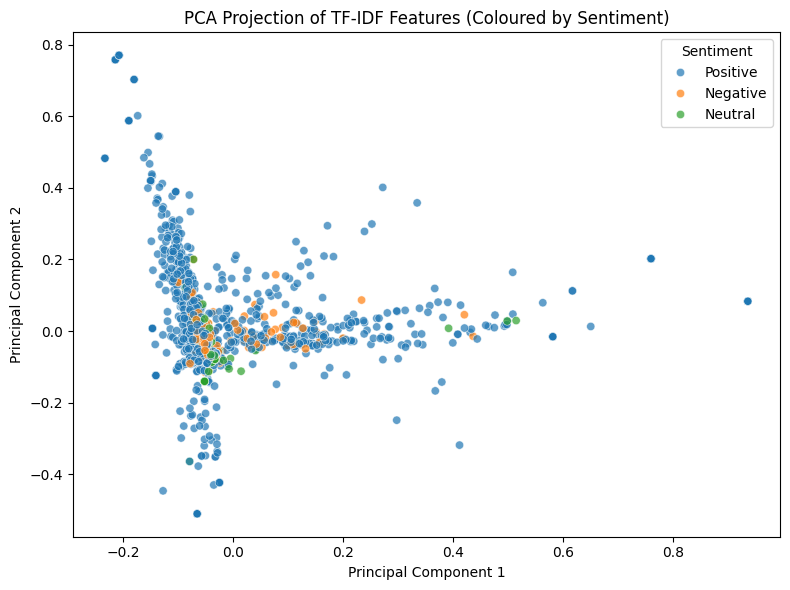

In [32]:
# Part F – PCA + Hierarchical Clustering

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------
# 1. PCA: reduce TF-IDF vectors to 2D
# ---------------------------------------------------------

# Convert sparse TF-IDF matrix to dense for PCA
X_dense = X_tfidf.toarray()

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_dense)

# Store components in the dataframe
df_sample['PC1'] = X_pca[:, 0]
df_sample['PC2'] = X_pca[:, 1]

print("Explained variance by PC1 and PC2:",
      pca.explained_variance_ratio_)

# ---------------------------------------------------------
# 2. Scatterplot of PCA components coloured by Sentiment
# ---------------------------------------------------------

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_sample,
    x='PC1',
    y='PC2',
    hue='Sentiment',
    alpha=0.7
)
plt.title("PCA Projection of TF-IDF Features (Coloured by Sentiment)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


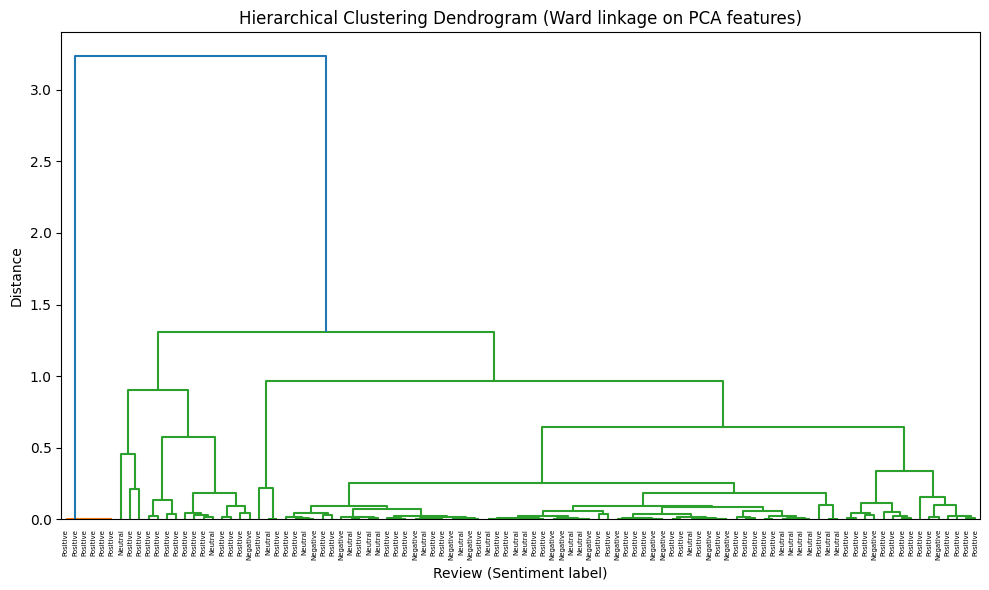

In [33]:
from scipy.cluster.hierarchy import linkage, dendrogram

# ---------------------------------------------------------
# 3. Sample a subset for dendrogram (e.g. 100 reviews)
# ---------------------------------------------------------

subset_size = min(100, len(df_sample))
df_subset = df_sample.sample(n=subset_size, random_state=123)

# Use the same PCA-reduced features for clustering
X_subset = df_subset[['PC1', 'PC2']].values

# ---------------------------------------------------------
# 4. Ward hierarchical clustering
# ---------------------------------------------------------

Z = linkage(X_subset, method='ward')  # uses Euclidean distance on PC1, PC2

plt.figure(figsize=(10, 6))
dendrogram(
    Z,
    labels=df_subset['Sentiment'].tolist(),  # label leaves by Sentiment
    leaf_rotation=90
)
plt.title("Hierarchical Clustering Dendrogram (Ward linkage on PCA features)")
plt.xlabel("Review (Sentiment label)")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()
